### Imports

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

### Data processing

In [2]:
# The data had initial rows (1-6) that were not part of the table. I manually deleted these to preprocess and columns that I thought were uninteresting
# I then saved that file as .csv
# You all may just use the .csv files in this folder as is, just wanted to share what happened previously

#Read in file
arrests = pd.read_csv('arrests.csv')#('2025-ICLI-00019_2024-ICFO-39357_ERO Admin Arrests.csv')

#Data cleaning
arrests = arrests.dropna(subset = 'Birth Year')
# This allows me to see all columns
# print(arrests.columns)

# This lets you see the data in the first row
print(arrests.iloc[0])

# This allows you to see the top five rows; often truncates columns which is why I did the above
arrests.head()

Apprehension Date      08/07/2024 9:43
Apprehension State            VIRGINIA
Departed Date               08/19/2024
Departure Country             HONDURAS
Birth Year                        1981
Citizenship Country           HONDURAS
Gender                            Male
Name: 0, dtype: object


,Apprehension Date,Apprehension State,Departed Date,Departure Country,Birth Year,Citizenship Country,Gender
0,08/07/2024 9:43,VIRGINIA,08/19/2024,HONDURAS,1981,HONDURAS,Male
1,10/19/2024 20:33,TEXAS,10/22/2024,MEXICO,1984,MEXICO,Male
2,04/15/2025 10:08,NEW JERSEY,06/10/2025,DOMINICAN REPUBLIC,1988,DOMINICAN REPUBLIC,Male
3,06/03/2025 9:20,MINNESOTA,NaN,NaN,1985,COLOMBIA,Female
4,01/21/2025 17:41,NaN,02/01/2025,MEXICO,1983,MEXICO,Male


In [3]:
# For arrests, the data does not have age (or birth date) but it does have birth year, so bucket by that
#Find the current year
current_year = datetime.datetime.today().year #2025
arrests['age'] = current_year - arrests['Birth Year']
arrests['Apprehension Date'] = pd.to_datetime(arrests['Apprehension Date'],format='%m/%d/%Y %H:%M')
arrests['Apprehension Day'] = arrests['Apprehension Date'].dt.date

## Histogram example

Text(0, 0.5, 'Count')

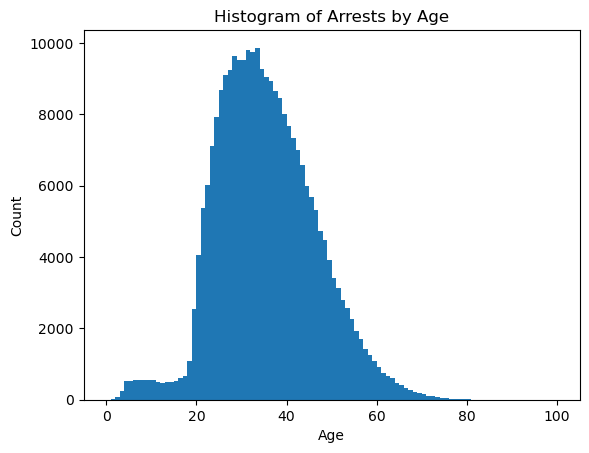

In [4]:
#Get every ten years for group, assume 100 is oldest group
agegroup = 1# Can do 10 to group by ten years
bins = np.linspace(0,100,int((100/agegroup))+1)

# Plot and label
plt.hist(arrests['age'], bins=bins)
plt.title('Histogram of Arrests by Age')
plt.xlabel('Age')
plt.ylabel('Count')

## Density Example

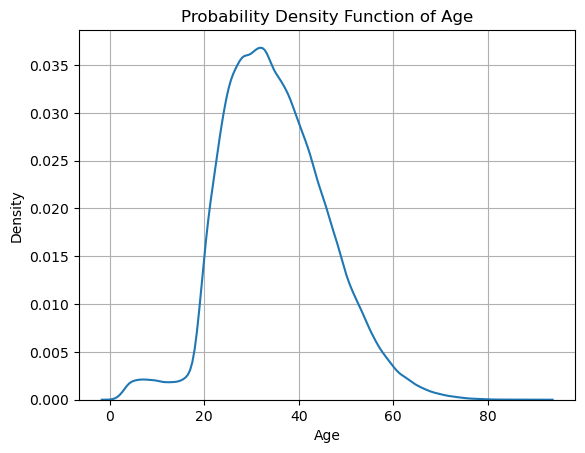

In [5]:
## Density example
import seaborn as sns
sns.kdeplot(arrests['age'], bw_adjust=1)  # `bw_adjust` can tweak smoothness
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Probability Density Function of Age')
plt.grid(True)

## Any observations on this graph?

### Time series

In [6]:
arrests_by_day = arrests.groupby(by='Apprehension Day').count().reset_index()

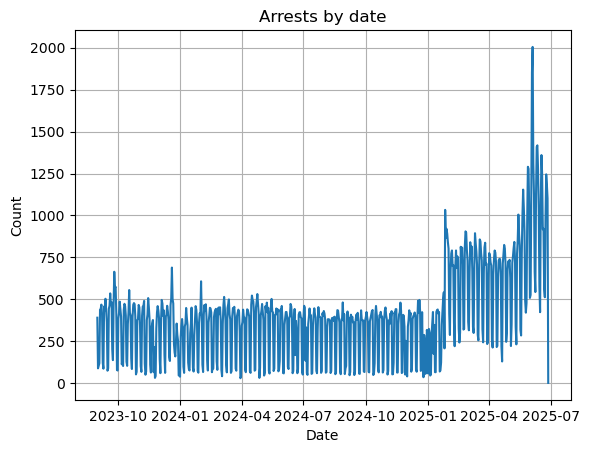

In [7]:
plt.plot(arrests_by_day['Apprehension Day'],arrests_by_day['age'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Arrests by date')
plt.grid(True)

### Ratio of removals

In [8]:
removals = pd.read_csv('removals.csv')#2025-ICLI-00019_2024-ICFO-39357_ICE Removals_2025.csv')
#The following was done in preprocessing
removals['Departed Date'] = pd.to_datetime(removals['Departed Date'],format='%Y-%m-%d').dt.date

In [9]:
# removals = pd.read_csv('2025-ICLI-00019_2024-ICFO-39357_ICE Removals_2025.csv')[['Departed Date', 'Departure Country', 'Gender',
#        'Birth Country', 'Citizenship Country', 'Birth Year', 'Entry Date']]
# removals['Departed Date']= pd.to_datetime(removals['Departed Date'],format='%m/%d/%Y').dt.date
# removals.to_csv('removals.csv',index=False)

In [10]:
#Get count of removals by day
removals_by_day = removals.groupby(by='Departed Date').count().reset_index()

In [11]:
#align days for arrests and removals
combined_df = arrests_by_day.merge(removals_by_day,how='left', left_on='Apprehension Day', right_on='Departed Date')
combined_df.head()

,Apprehension Day,Apprehension Date,Apprehension State,Departed Date_x,Departure Country_x,Birth Year_x,Citizenship Country_x,Gender_x,age,Departed Date_y,Departure Country_y,Gender_y,Birth Country,Citizenship Country_y,Birth Year_y,Entry Date
0,2023-09-01,390,285,219,219,390,390,390,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-02,88,34,23,23,88,88,88,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-03,103,39,36,36,103,103,103,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-04,118,78,59,58,118,118,118,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-05,438,309,197,197,438,438,438,438,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Chose generic columns with counts
combined_df['ratio'] = combined_df['Apprehension Date']/combined_df['Birth Year_y']
combined_df = combined_df.dropna(subset = 'ratio')

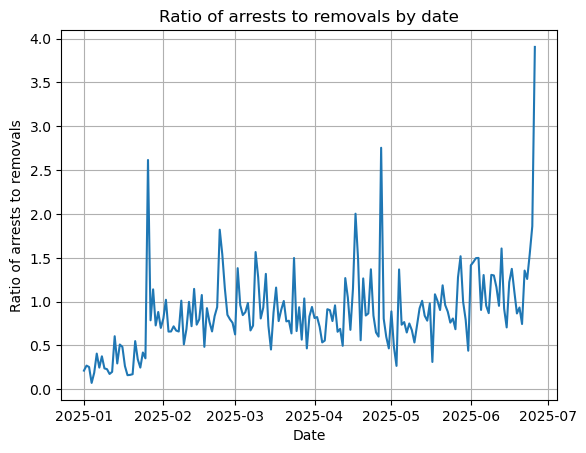

In [13]:
plt.plot(combined_df['Apprehension Day'],combined_df['ratio'])
plt.xlabel('Date')
plt.ylabel('Ratio of arrests to removals')
plt.title('Ratio of arrests to removals by date')
plt.grid(True)

### Summary stats

In [14]:
summary = arrests.groupby('Apprehension Day')['age'].agg(
    mean='mean',
    median='median',
    mode=lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    percentile_25=lambda x: x.quantile(0.25),
    percentile_75=lambda x: x.quantile(0.75)
).reset_index()

In [15]:
summary

,Apprehension Day,mean,median,mode,percentile_25,percentile_75
0,2023-09-01,36.605128,36.0,31,28.00,44.0
1,2023-09-02,34.863636,33.0,31,29.00,38.0
2,2023-09-03,34.631068,34.0,34,27.00,42.0
3,2023-09-04,35.610169,35.0,22,28.00,43.0
4,2023-09-05,33.840183,33.0,31,26.25,42.0
...,...,...,...,...,...,...
661,2025-06-23,35.732724,34.0,27,27.00,43.0
662,2025-06-24,35.391968,34.0,32,27.00,42.0
663,2025-06-25,35.138397,34.0,25,27.00,42.0
664,2025-06-26,34.790191,33.0,28,27.00,42.0


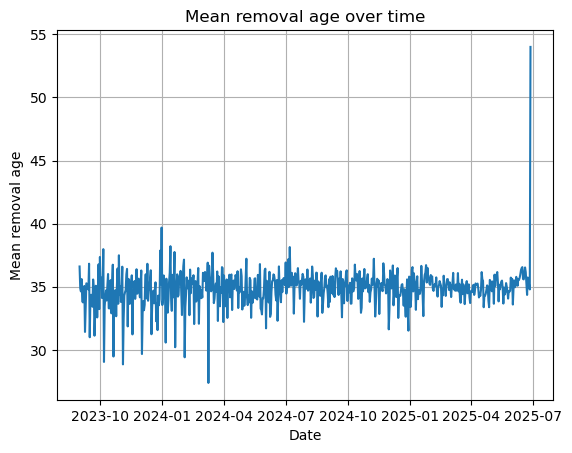

In [16]:
plt.plot(summary['Apprehension Day'],summary['mean'])
plt.xlabel('Date')
plt.ylabel('Mean removal age')
plt.title('Mean removal age over time')
plt.grid(True)

### Scatter Plot

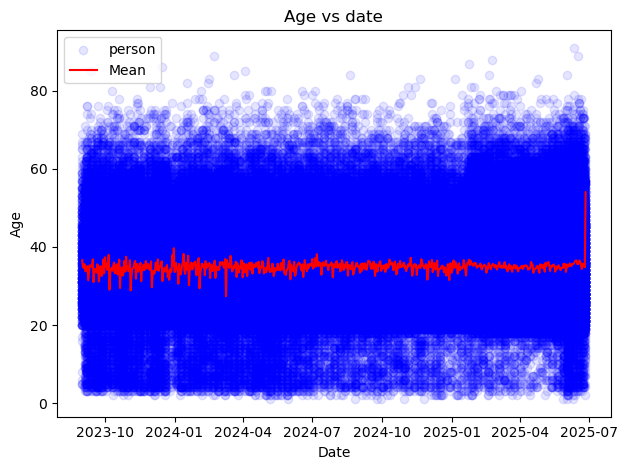

In [17]:
plt.scatter(arrests['Apprehension Day'],arrests['age'],alpha=0.1,color='b',label='person')
plt.plot(summary['Apprehension Day'],summary['mean'],color='r',label='Mean')
plt.xlabel('Date')
plt.ylabel('Age')
plt.title('Age vs date')
plt.legend()
plt.tight_layout()
plt.savefig('ScatterIllegible.PNG')

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

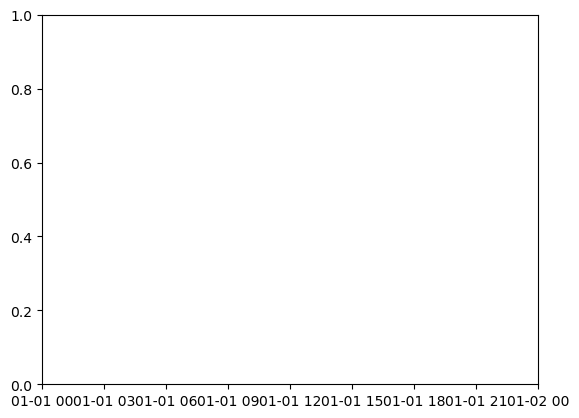

In [ ]:
import matplotlib.dates as mdates
from scipy.stats import gaussian_kde
x = mdates.date2num(arrests['Apprehension Day'])
y = arrests['age'].values
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(arrests['Apprehension Day'],arrests['age'],alpha=0.1,c=z,label='person')
plt.plot(summary['Apprehension Day'],summary['mean'],color='r',label='Mean')
plt.xlabel('Date')
plt.ylabel('Age')
plt.title('Age vs date')
plt.legend()
plt.tight_layout()
plt.savefig('Scatter.PNG')

What is happening on the last day? Let's look closer

In [ ]:
arrests.loc[arrests['Apprehension Day']==max(arrests['Apprehension Day'])]

Turns out there is only one data point for this specific date, so we shouldn't worry too much about the weird data point